# Background: The AR(1) Process #

In [526]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import random

# Seed RNG (for reproducibility)
seed = 100
np.random.seed(seed)

In this experiement we will investigate the applicability of MAML to time series forecasting tasks, in particular whether the method allows a neural network model to adapt to non-stationarity in a stochastic process.

For this experiment we will target the AR(1) process $X_t$ given by:

$X_{t} = \alpha X_{t-1} + \epsilon_t$

where $\alpha \in \mathbb{R}$, $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$ are **i.i.d** noise terms with constant error variance $\sigma^2$.

The goal will be to vary $\alpha$ and $\sigma$ and see if a neural network forecasting model is able to rapidly adapt to new processes with different coefficients.

The following code snippet produces samples from an AR(1) process:

In [487]:
# Sample from AR(1) process.
def sample_ar_1(alpha, sigma, T=1000):
    ''' Sample T steps from an AR(1) process with noise variance sigma and AR-coefficient alpha'''
    noise = np.random.normal(0, sigma, T+1)
    X = np.zeros(T)

    for n in range(1,T):
        X[n] = (alpha*X[n-1]) + noise[n]
    return X

We illustrate the AR process with different settings of $\alpha$ sampled with constant error variance 2.
Notice how as $\alpha \rightarrow 1$ contribution from the previous term becomes more relevant compared to the noise, transforming it from an almost white-noise sequence for $\alpha=0.1$ to something with significant autocorrelation at $\alpha=0.9$.


Text(0, 0.5, 'Alpha = 0.1')

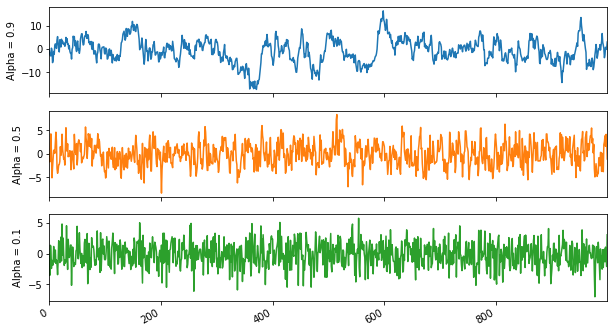

In [219]:
# Visualisation of an AR(1)
var = 2
df = pd.DataFrame()
df['a=0.9'] = sample_ar_1(0.9, var)
df['a=0.5'] = sample_ar_1(0.5, var)
df['a=0.1'] = sample_ar_1(0.1, var)
axes = df.plot(figsize=(10, 6), subplots=True, sharex=True, legend=False)
axes[0].set_ylabel('Alpha = 0.9')
axes[1].set_ylabel('Alpha = 0.5')
axes[2].set_ylabel('Alpha = 0.1')

It is simple to show the autocorrelation function of an AR(1) process is given by $\gamma(\delta) = \alpha^{\delta}$.
By inspection of $\gamma(\cdot)$ the process is unstable for $|\alpha|>1$ as shocks will be magnified over time (even if the mean is zero). 

We illustrate this below by taking just 30 samples of an AR(1) process with $\alpha=1.5$:

Text(0, 0.5, 'Alpha=1.5')

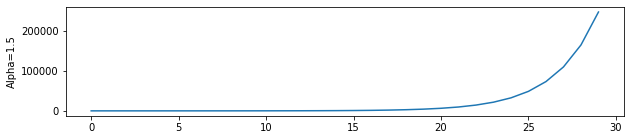

In [228]:
fig, axes = plt.subplots(figsize=(10,2))
axes.plot(sample_ar_1(1.5, var, 30)) # Unstable AR process
axes.set_ylabel('Alpha=1.5')

# Using an ANN model to forecast an AR(1) #

We will now verify if a simple ANN model can recover an AR(1) coefficient. The following Tensorflow code is adapted from https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb#scrollTo=q5P2yS3GB2aP. TODO: Better way to reference in Jup?

In [533]:
# The goal is to train NN to predict the next value given the current value
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import sklearn.metrics
import statsmodels.api as sm
import time

tf.keras.backend.set_floatx('float64')
    
class ARModel(keras.Model):
    '''Model to forecast the next value of a stochastic process'''
    def __init__(self, name='ANN'):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        self.model_name = name
        self.k_shot = False
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

    def set_kshot(self):
        self.k_shot = True
        self.model_name = self.model_name + '_kshot'
    
class LinearModel:
    ''' Linear model used for benchmark forecasting '''
    def __init__(self, alpha):
        self.alpha = alpha
        self.model_name = 'Linear'
        self.k_shot = False
        
    def forward(self, x):
        return alpha*x
    
class OLS_AR_Model:
    ''' An OLS model to 1-step forecast an AR(1) process'''
    def __init__(self):
        self.model_name = 'OLS'
        self.k_shot = False
        self.res = None
        
    def train(self, train_dataset):
        x = np.array([ts[:-1] for ts in train_dataset]).flatten()
        y = np.array([ts[1:] for ts in train_dataset]).flatten()
        self.res = sm.OLS(y, x).fit()
        
    def forward(self, x):
        return self.res.predict(x)
    
def copy_model(model, x):
    '''Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = ARModel(model.model_name)

    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))

    copied_model.set_weights(model.get_weights())
    return copied_model

In [491]:
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    
def compute_loss(model, x, y, loss_fn=loss_function):
    preds = model.forward(x)
    mse = loss_fn(preds, y)
    return mse, preds


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = ARModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, x in enumerate(dataset): # dataset will be vector of time-series here
            loss = train_batch(x[:-1,None], x[1:,None], model, optimizer) # Training data is x_t, test is x_t+1 (hence the need to trim).
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

We fit the model to 1000 (randomly generated) batches of 1000 timesteps of an AR(1) process with $\alpha=0.8$.

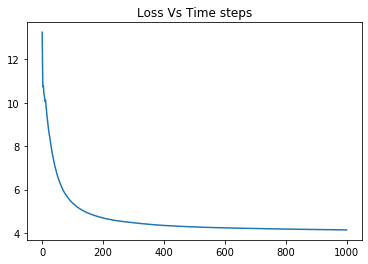

In [233]:
train_dataset = [sample_ar_1(0.8, 2, 1000) for i in range(1000)]
stationary_model = train_model(train_dataset)

We now compare the model forecast to the true optimal forecast (in terms of mean squared error), that is that conditional expectation: $\mathbb{E}[X_{t+1}|X_t=x] = 0.8x + 0 = 0.8x$.

In [364]:
def calc_r2_1_step(data, forecasts):
    return sklearn.metrics.r2_score(data[1:], forecasts[:-1])

def benchmark_model(model, alpha, var, N=100, validation_set=None):
    if validation_set is None:
        x = sample_ar_1(alpha, var, 100)
    else:
        x = validation_set
    y = model.forward(tf.convert_to_tensor(x[:,None]))
    
    # Benchmark - linear forecast
    lin = alpha*x

    # Plot results
    plt.plot(x[1:], label='AR(1)')
    plt.plot(y[:-1], label='Model_pred')
    plt.plot(lin, label='Optimal_pred')
    plt.legend()
    plt.show()
    
    #Compute R2
    print('Model R2: {}'.format(calc_r2_1_step(x, y)))
    print('Linear R2: {}'.format(calc_r2_1_step(x, lin)))

0.689787761666278
0.6892404689155116


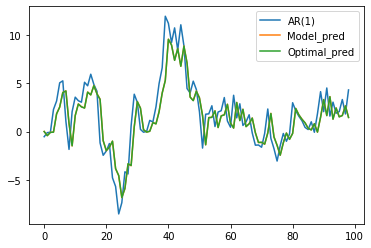

In [234]:
benchmark_model(stationary_model, 0.8, 2)

Graphically the two are near indistinguishable with very similar $R^2$ scores. We repeat this trial 1000 times and evaluate the mean and variance of the **difference** of these two scores.

In [236]:
scores = np.zeros(1000)
for i in range(len(scores)):
    x = sample_ar_1(0.8, 2, 100)
    y = stationary_model.forward(tf.convert_to_tensor(x[:,None]))

    # Benchmark - linear forecast
    lin = np.zeros(len(x)-1)
    lin = 0.8*x[:-1]
    scores[i] = sklearn.metrics.r2_score(x[1:], lin) - sklearn.metrics.r2_score(x[1:], y[:-1])

print('Mean: {}'.format(scores.mean()))
print('Var: {}'.format(scores.var()))

Mean: 0.0001215108182448632
Var: 4.0837918053775877e-07


We observe that the difference is almost indistinguishable and very stable, concluding that the ANN model is able to learn $\alpha$ to near machine precision (this is not surprising).

# Forecasting non-stationary AR(1) models # 

We know that an ANN can learn one parameter, but what happens if we start to vary these parameters and predict a new time series with k-shot prediction?
The experiment involves training an ANN model on a sequence of N non-stationary time series (with AR parameter $\alpha_n, n=1,\dots,N$), then giving it a chance to k-shot learn from a new time series (say for 10 steps) and measure the predictive performance on this new time series.

We start by illustrating the difference in performance when we train on non-stationary samples and test out of sample with a new AR coefficient. In initial experiments we found when sampling $\alpha_n \sim \mathcal{u}[0,1]$ that the network performed remarkably well, but that this was due to it simply learning the training set for different AR coefficients. We therefore changed the experiment to have all the series in the training set sample $\alpha_n \sim \mathcal{u}[0,\frac{1}{2}]$ and then evaluating on a test AR process with $\alpha=0.8$, testing whether a vanilla ANN can learn to generalise in this way (we do not expect it a-priori to be able to handle such a shift):

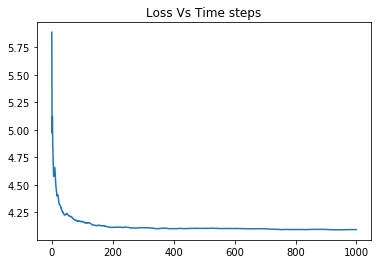

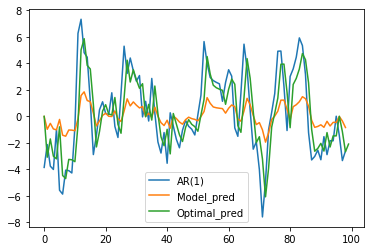

Model R2: 0.30667917993443083
Linear R2: 0.5554974002783902


In [365]:
def make_nonstat_dataset(N=1000, ub=.5, var=2):
    alphas = np.random.uniform(0, .5, N)
    return np.array([sample_ar_1(alphas[i], var, int(1000000/N)) for i in range(N)])

train_dataset = make_nonstat_dataset()
nonstat_model = train_model(train_dataset)
benchmark_model(nonstat_model, .8, 2)

We notice there is a substantial drop off in performance. We now allow for k-shot learning with $k = 10$ steps extra of the new series and once again evaluate the performance. We note that the number of steps needed is some function of the variance, so we may need to take this into account:

In [517]:
def benchmark_models_kshot(models, trials=1000, N=100, k=10, alpha=.8, var=2):
    opt = keras.optimizers.Adam(learning_rate=0.001)
    r2s = pd.DataFrame(columns=[model.model_name for model in models])
    for i in range(trials):
        sample = sample_ar_1(alpha, var, N)
        kshot = sample[:k+1] # k samples to use for k-shot learning
        # NOTE: I put k+1 here as we need to use 0-k-1 for inputs and 1-k for outputs - k total samples but need to grab a few more.
        val = sample[k+1:] # Validation set
        
        for model in models:
            if model.k_shot == True: # If we want to perform k-shot learning on this model.
                _model = copy_model(model, val[:,None]) # Copy the model so that we don't just keep boosting the original model each time.
                l = train_batch(kshot[:k,None], kshot[1:,None], _model, opt) # Train using the k-shot samples
            else:
                _model = model
            y = _model.forward(tf.convert_to_tensor(val[:,None]))
            r2s.loc[i, model.model_name] = calc_r2_1_step(val, y)
    return r2s.infer_objects()
#         # Benchmark - linear forecast
#         lin = test_alpha*val

In [367]:
# print('Base model R2 | Mean: {} Std: {}'.format(base_r2.mean(), base_r2.std()))
# print('k-shot model R2 | Mean: {} Std: {}'.format(kshot_r2.mean(), kshot_r2.std()))
# print('Linear model R2 | Mean: {} Std: {}'.format(lin_r2.mean(), lin_r2.std()))
# print(stats.ttest_ind(base_r2, kshot_r2))

Base model R2 | Mean: 0.24870355373143052 Std: 0.106448153360169
k-shot model R2 | Mean: 0.2626318828561225 Std: 0.10345925096492394
Linear model R2 | Mean: 0.5733954126426786 Std: 0.11367605175211096
Ttest_indResult(statistic=-2.9656847322562117, pvalue=0.0030559000801366224)


We notice the k-shot provides relatively small improvement over the base model in this case with a positive test result that they are both drawn from the same (Gaussian) population. We now utilise the MAML algorithm and investigate the performance:

In [518]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=500):
    '''Train using the MAML setup.
    
    The comments in this function that start with:
        
        Step X:
        
    Refer to a step described in the Algorithm 1 of the paper.
    
    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.
    
    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()
    
    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(list(dataset), len(dataset))):
            x, y = np_to_tensor((t[:-1, None], t[1:, None]))
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    # Following two lines are gradient descent steps applied manually
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

Step 1000: loss = 4.108877951483872, Time to run 1000 steps = 3.17 seconds
Step 2000: loss = 4.089335179655468, Time to run 1000 steps = 3.33 seconds
Step 3000: loss = 4.097997247495836, Time to run 1000 steps = 3.04 seconds
Step 4000: loss = 4.098377772261043, Time to run 1000 steps = 3.02 seconds
Step 5000: loss = 4.099828268028772, Time to run 1000 steps = 3.03 seconds
Step 6000: loss = 4.098371897814598, Time to run 1000 steps = 2.99 seconds
Step 7000: loss = 4.0987429258938555, Time to run 1000 steps = 3.02 seconds
Step 8000: loss = 4.098964193874766, Time to run 1000 steps = 3.01 seconds
Step 9000: loss = 4.100004953827128, Time to run 1000 steps = 2.97 seconds


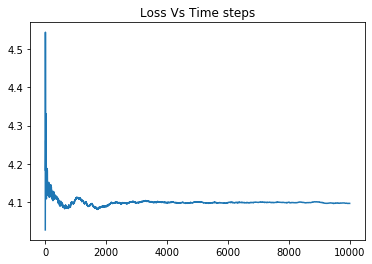

Step 500: loss = 4.040033724658363, Time to run 500 steps = 8.710397958755493
Step 1000: loss = 3.996356237377943, Time to run 500 steps = 8.747409582138062
Step 1500: loss = 3.9612116586467123, Time to run 500 steps = 9.081178665161133
Step 2000: loss = 3.946436575379, Time to run 500 steps = 9.034717798233032
Step 2500: loss = 3.943778990946086, Time to run 500 steps = 9.761560201644897
Step 3000: loss = 3.9417538192416317, Time to run 500 steps = 9.736286163330078
Step 3500: loss = 3.937646945621758, Time to run 500 steps = 8.87320065498352
Step 4000: loss = 3.9319632171678345, Time to run 500 steps = 8.938959836959839
Step 4500: loss = 3.927635730668872, Time to run 500 steps = 8.799787998199463
Step 5000: loss = 3.925345976946307, Time to run 500 steps = 8.963376998901367
Step 5500: loss = 3.9209374653164035, Time to run 500 steps = 8.756056785583496
Step 6000: loss = 3.9177182123910566, Time to run 500 steps = 8.90420651435852
Step 6500: loss = 3.9149714559175144, Time to run 500

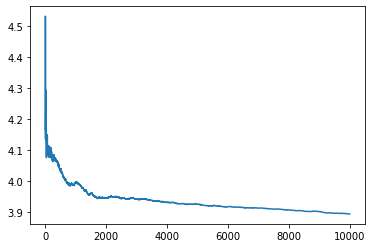

In [514]:
train_dataset = make_nonstat_dataset(N=10000)

ANN = train_model(train_dataset)

maml_model = ARModel(name='ANN_MAML')
train_maml(maml_model, 1, train_dataset)

# ols_model = OLSModel()
# ols_model.train(train_dataset)

In [534]:
test_alpha = .8
test_var = 2
init = train_dataset[0][:, None] # Dataset for initialization forward pass for copied models - does not influence training or testing at all

kshot_MAML = copy_model(maml_model, init)
kshot_MAML.set_kshot()

kshot_ANN = copy_model(ANN, init)
kshot_ANN.set_kshot()

ols = OLS_AR_Model()
ols.train(train_dataset)

models = [ANN, kshot_ANN, maml_model, kshot_MAML, ols, LinearModel(alpha)]

r2s = benchmark_models_kshot(models, alpha=test_alpha, var=test_var).infer_objects()

<class 'numpy.ndarray'> [ 0.          1.57385503 -3.5730297  -1.63350851 -1.57918975]


In [537]:
r2s.describe()
ols.res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.068
Model:                            OLS   Adj. R-squared (uncentered):              0.068
Method:                 Least Squares   F-statistic:                          7.271e+04
Date:                Wed, 20 Nov 2019   Prob (F-statistic):                        0.00
Time:                        15:21:02   Log-Likelihood:                     -2.1022e+06
No. Observations:              990000   AIC:                                  4.204e+06
Df Residuals:                  989999   BIC:                                  4.205e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2629      0.001    269.642      0.000       0.261       0.265
==============================================================================
Omnibus:                        0.993   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.609   Jarque-Bera (JB):                0.997
Skew:                           0.002   Prob(JB):                        0.607
Kurtosis:                       2.997   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""